In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="Faiza@123",
                            database="ecommerce")
cur = db.cursor()

#  list all unique cities where customers are located.  

In [79]:
query=""" select distinct customer_city from customers"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017 

In [80]:
query=""" select count( order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)
data=cur.fetchall()
"total orders placed in 20217 are" ,data[0][0]

('total orders placed in 20217 are', 90202)

# Find the total sales per category.


In [82]:
query=""" select upper(products.product_category) category,sum(payments.payment_value) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["category","sales"])
df


,category,sales
0,PERFUMERY,5.067387e+05
1,FURNITURE DECORATION,1.430176e+06
2,TELEPHONY,4.868821e+05
3,BED TABLE BATH,1.712554e+06
4,AUTOMOTIVE,8.522943e+05
...,...,...
69,CDS MUSIC DVDS,1.199430e+03
70,LA CUISINE,2.913530e+03
71,FASHION CHILDREN'S CLOTHING,7.856700e+02
72,PC GAMER,2.174430e+03


# Calculate the percentage of orders that were paid in installments.


In [83]:
query=""" select (sum(case when payment_installments>=1 then 1
else 0 end))/count(*)*100 from payments"""

cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments is ",data[0]

('the percentage of orders that were paid in installments is ',
 (Decimal('99.9981'),))

# Count the number of customers from each state. 


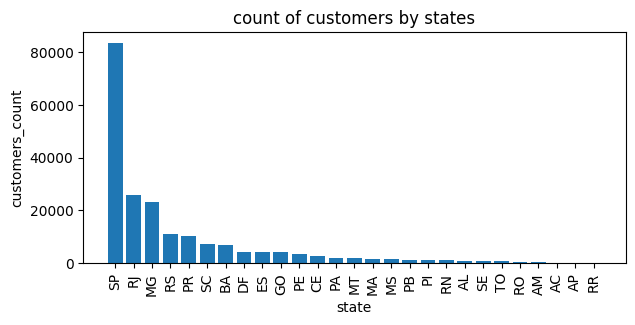

In [84]:

query=""" select customer_state,count(customer_id)from customers 
group by customer_state"""

cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["state","customers_count"])
df=df.sort_values(by="customers_count",ascending=False)
plt.figure(figsize=(7,3))
plt.bar(df["state"],df["customers_count"])
plt.xlabel("state")
plt.ylabel("customers_count")
plt.xticks(rotation=90)
plt.title("count of customers by states")
plt.show()


#  Calculate the number of orders per month in 2018.


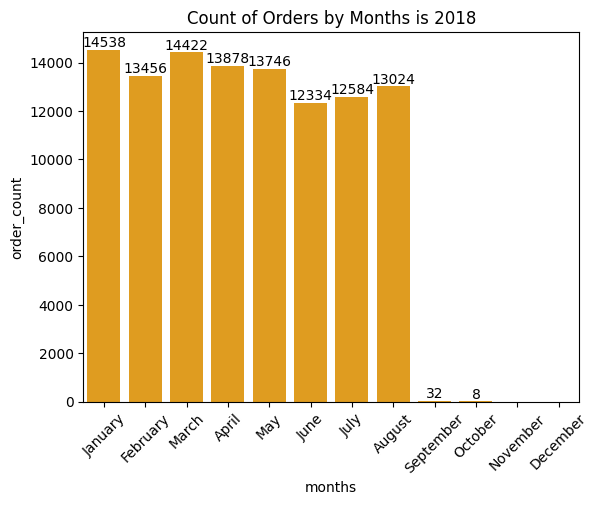

In [85]:
query=""" select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018 group by months """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])

o= ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sns.barplot(x=df["months"],y=df["order_count"], data=df ,order=o, color = "orange")
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.xticks(rotation=45)
plt.show()

 #  Find the average number of products per order, grouped by customer city.


In [86]:
query=""" with count_per_order as(select orders.order_id,orders.customer_id,count(order_items.order_id) as order_count
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order. order_count),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city","average products/order"])
df.head(10)

,customer_city,average products/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


#  Calculate the percentage of total revenue contributed by each product category.


In [87]:
query="""
select upper(products.product_category) product_category,round((sum(payments.payment_value) / (select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by product_category order by sales_percentage desc"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["product_category","percentage distribution"])
df.head(10)

,product_category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


#  Identify the correlation between product price and the number of times a product has been purchased.


In [94]:
query="""select products.product_category,count(order_items.product_id) as order_count,
round(avg(order_items.price),2) as avg_price
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["product_category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]

a=np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157567


#  Calculate the total revenue generated by each seller, and rank them by revenue.


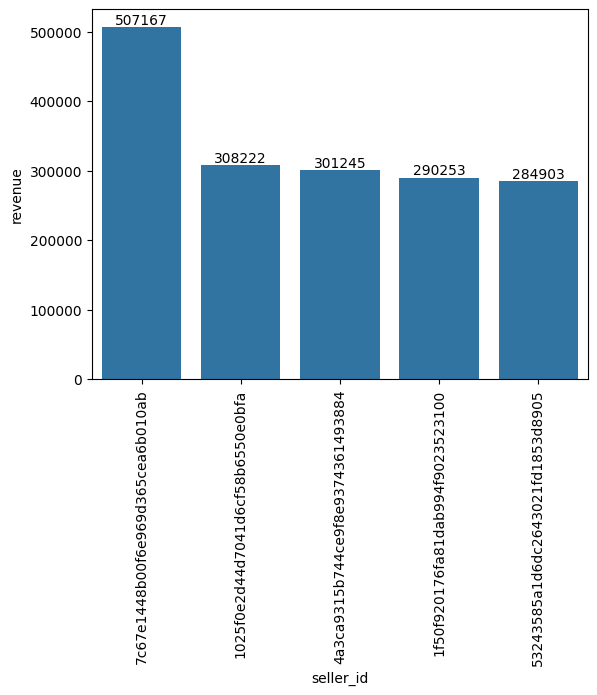

In [102]:
query="""select*, dense_rank()over(order by revenue desc)as rn
from (select order_items.seller_id,sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head(5)
ax=sns.barplot(x="seller_id",y="revenue",data=df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

#  Calculate the moving average of order values for each customer over their order history


In [105]:
query=""" select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id,order_purchase_timestamp rows between 2 preceding and current row)as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns= ["customer_id","order_purchase_timestamp","payment","mov_avg"])
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


#  Calculate the cumulative sales per month for each year.


In [116]:
query=""" select years,months,payment,
round(sum(payment)over (order by years,months),2) cumilative_sales 
from(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value ),2) as payment
from payments join orders
on payments.order_id=orders.order_id
group by years,months) as a order by years,months """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns= ["years","months","payment","cumulative sales"])
df
# df.columns=["years","months","payment","cumulative sales"]
# plt.bar(df[ "months"],df["cumulative sales"])
# plt.title("cumulative sales per month for each year")
# plt.show()

,years,months,payment,cumulative sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


#  Calculate the year-over-year growth rate of total sales.

In [120]:
query=""" with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value ),2) as payment
from orders join payments
on orders.order_id=payments.order_id
group by years order by years )


select years,((payment-lag(payment,1) over(order by years))/
lag(payment,1)over(order by years))*100 from a"""



cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns= ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [121]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data
# no customer is repated

[(None,)]

#  Identify the top 3 customers who spent the most money in each year

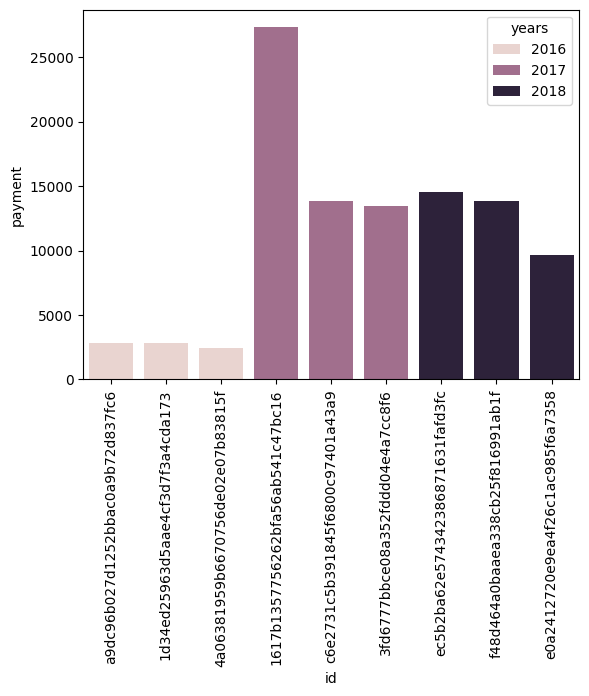

In [122]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()